# Number of Elements In The HOG Descriptor

The resulting HOG Descriptor (feature vector), contains the normalized histograms from all cells from all blocks in the detection window concatenated in one long vector. Therefore, the size of the HOG feature vector will be given by the total number of blocks in the detection window, multiplied by the number of cells per block, times the number of orientation bins:

<span class="mathquill">
\begin{equation}
\mbox{total_elements} = (\mbox{total_number_of_blocks})\mbox{ } \times \mbox{ } (\mbox{number_cells_per_block})\mbox{ } \times \mbox{ } (\mbox{number_of_bins})
\end{equation}
</span>

If we don’t have overlapping blocks (*i.e.* the `block_stride`equals the `block_size`), the total number of blocks can be easily calculated by dividing the size of the detection window by the block size. However, in the general case we have to take into account the fact that we have overlapping blocks. To find the total number of blocks in the general case (*i.e.* for any `block_stride` and `block_size`), we can use the formula given below:

<span class="mathquill">
\begin{equation}
\mbox{Total}_i = \left( \frac{\mbox{block_size}_i}{\mbox{block_stride}_i} \right)\left( \frac{\mbox{window_size}_i}{\mbox{block_size}_i} \right) - \left [\left( \frac{\mbox{block_size}_i}{\mbox{block_stride}_i} \right) - 1 \right]; \mbox{  for  } i = x,y
\end{equation}
</span>

Where <span class="mathquill">Total$_x$</span>, is the total number of blocks along the width of the detection window, and <span class="mathquill">Total$_y$</span>, is the total number of blocks along the height of the detection window. This formula for <span class="mathquill">Total$_x$</span> and <span class="mathquill">Total$_y$</span>, takes into account the extra blocks that result from overlapping. After calculating <span class="mathquill">Total$_x$</span> and <span class="mathquill">Total$_y$</span>, we can get the total number of blocks in the detection window by multiplying <span class="mathquill">Total$_x$  $\times$ Total$_y$</span>. The above formula can be simplified considerably because the `block_size`, `block_stride`, and `window_size`are all defined in terms of the `cell_size`. By making all the appropriate substitutions and cancelations the above formula reduces to:

<span class="mathquill">
\begin{equation}
\mbox{Total}_i = \left(\frac{\mbox{cells}_i - \mbox{num_cells_per_block}_i}{N_i}\right) + 1\mbox{  }; \mbox{  for  } i = x,y
\end{equation}
</span>

Where <span class="mathquill">cells$_x$</span> is the total number of cells along the width of the detection window, and <span class="mathquill">cells$_y$</span>, is the total number of cells along the height of the detection window. And <span class="mathquill">$N_x$</span> is the horizontal block stride in units of `cell_size` and <span class="mathquill">$N_y$</span> is the vertical block stride in units of `cell_size`. 

Let's calculate what the number of elements for the HOG feature vector should be and check that it matches the shape of the HOG Descriptor calculated above.

Using matplotlib backend: nbAgg
The gray scale image has shape:  (633, 950)
HOG Descriptor Parameters:
Window Size: (944, 632)
Cell Size: (8, 8)
Block Size: (16, 16)
Block Stride: (8, 8)
Number of Bins: 9


<IPython.core.display.Javascript object>


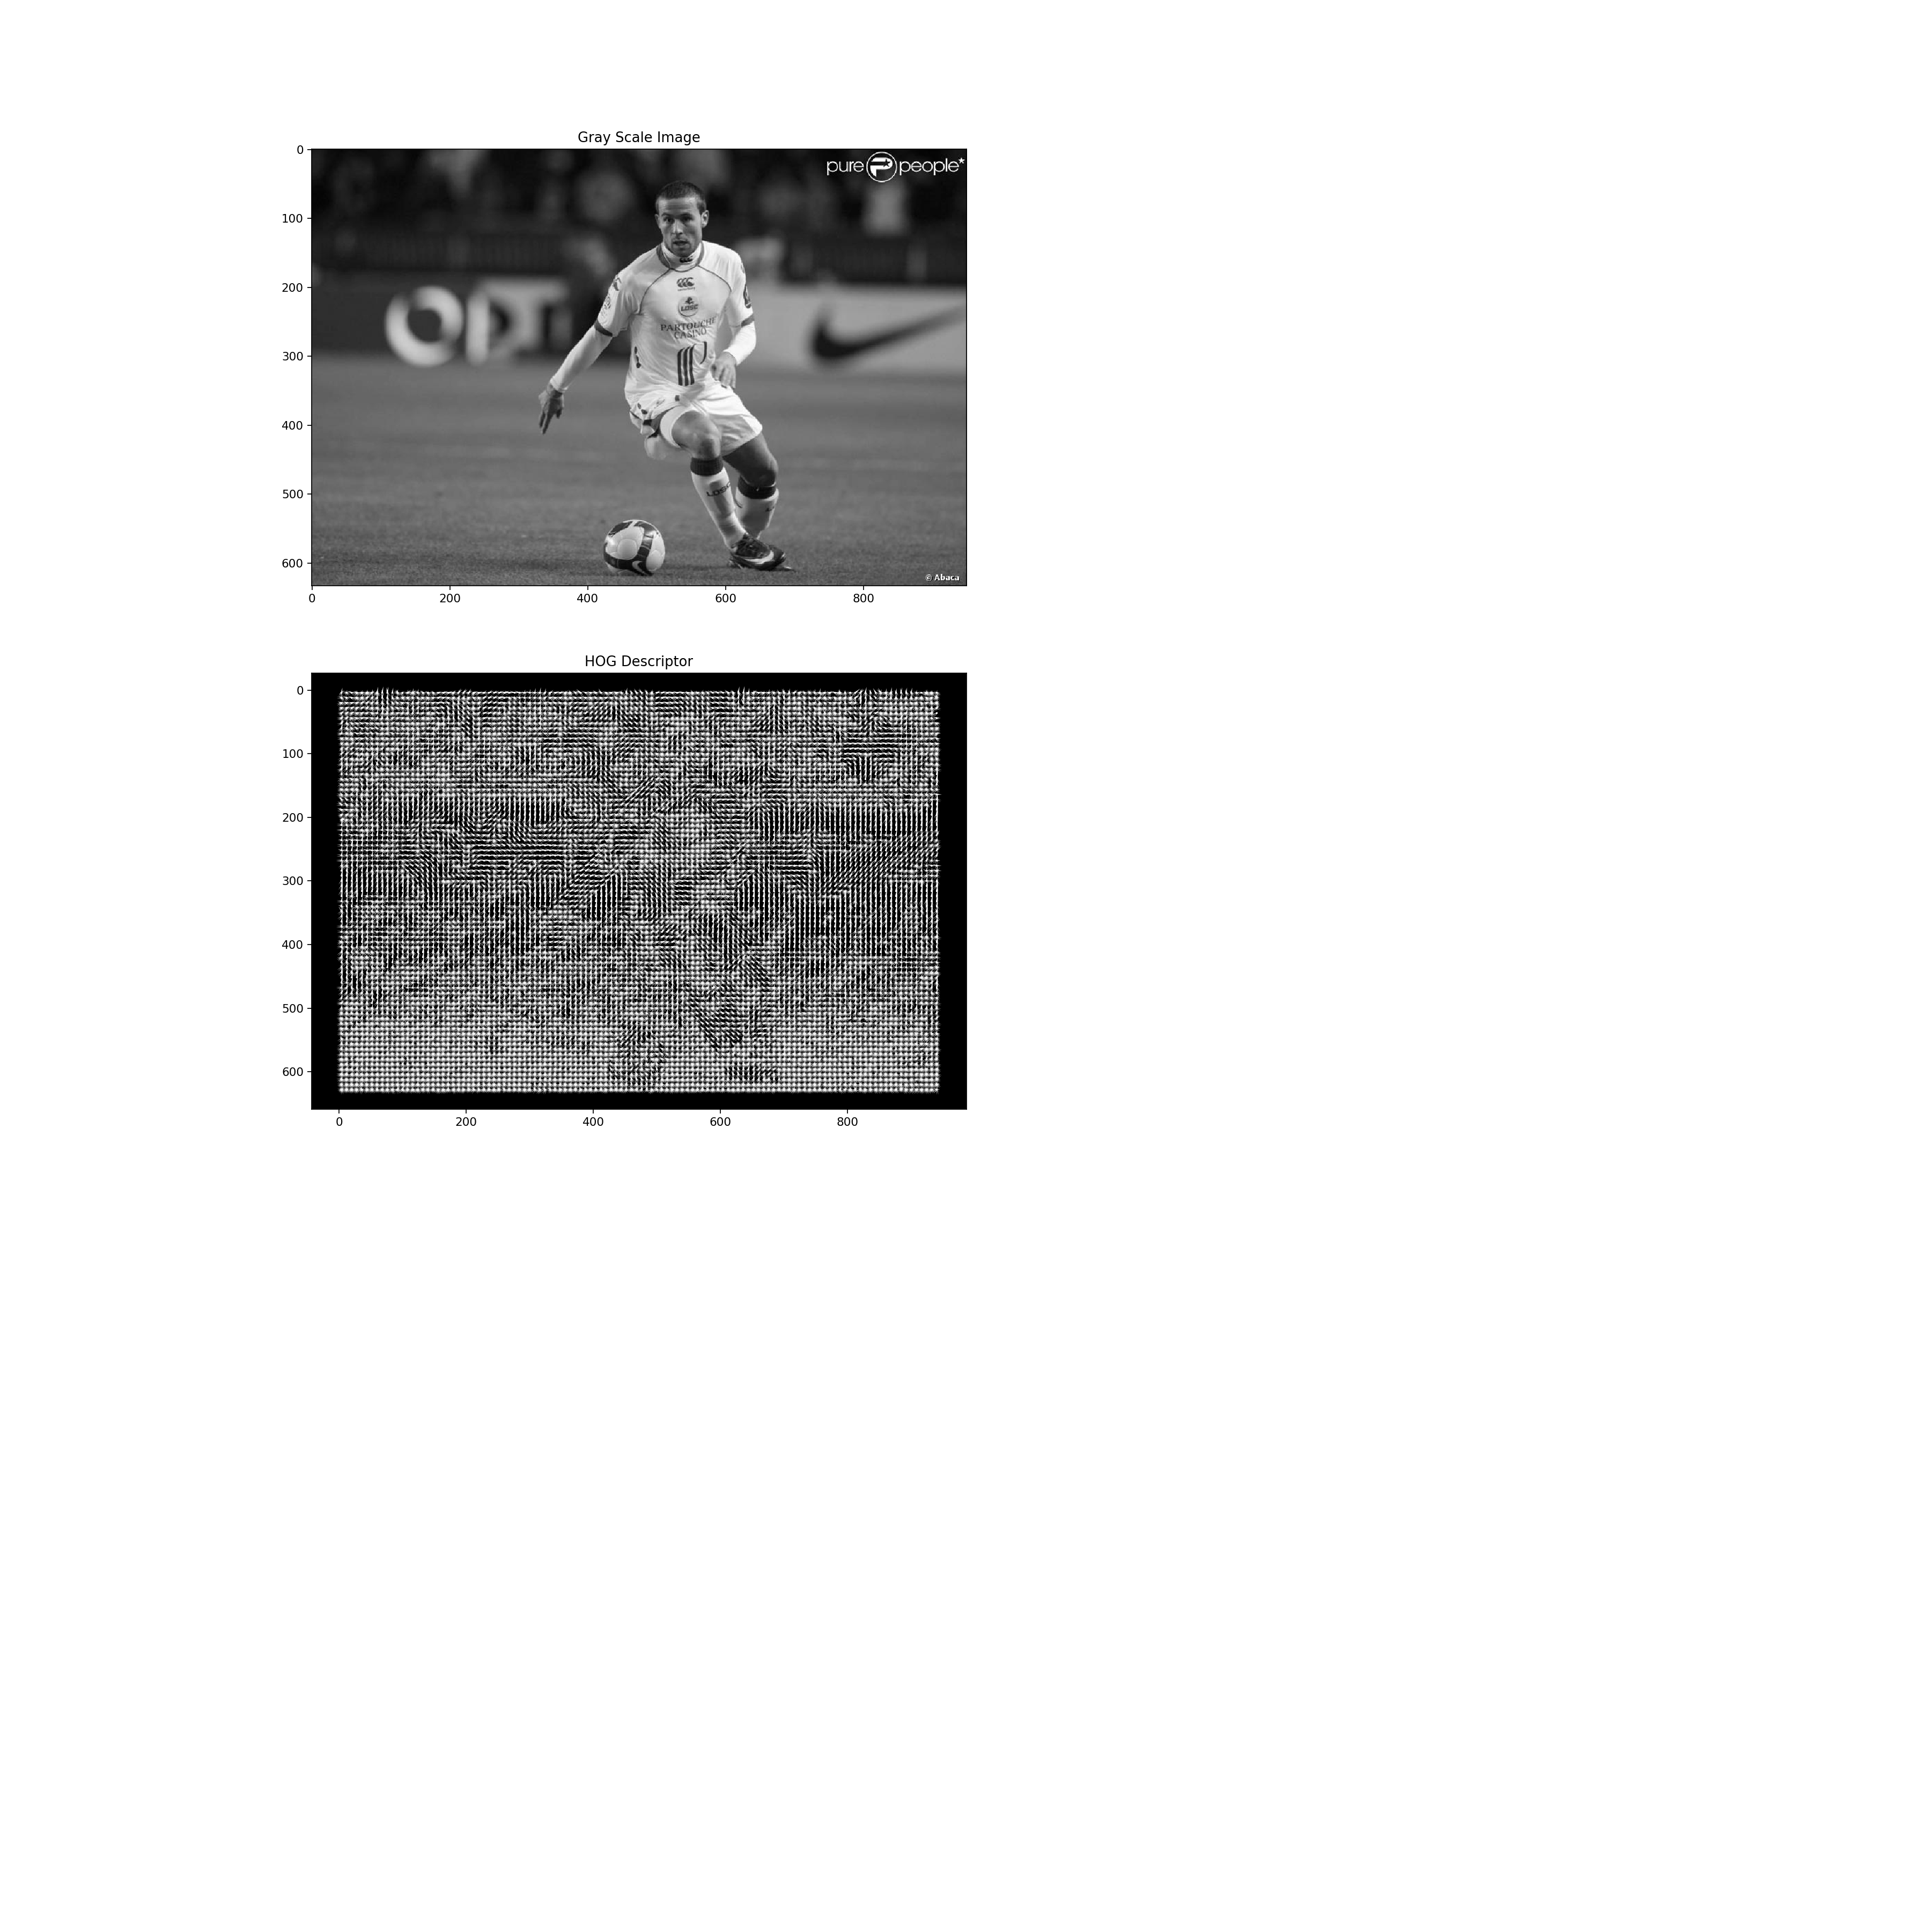

In [43]:
%matplotlib 

import cv2
import copy
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Set figure size
plt.rcParams['figure.figsize'] = [15,15]

# Load the image 
image = cv2.imread('C:/Users/jeanjules.bigeard/OneDrive - Neato Robotics/Documents/ski.jpg')

# Cell Size in pixels (width, height). Must be smaller than the size of the detection window
# and must be chosen so that the resulting Block Size is smaller than the detection window.
cell_size = (8, 8)

# Number of cells per block in each direction (x, y). Must be chosen so that the resulting
# Block Size is smaller than the detection window
num_cells_per_block = (2, 2)

# Number of gradient orientation bins
num_bins = 9

# Convert the original image to RGB
original_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the original image to gray scale
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)


# Block Size in pixels (width, height). Must be an integer multiple of Cell Size.
# The Block Size must be smaller than the detection window
block_size = (num_cells_per_block[0] * cell_size[0],
              num_cells_per_block[1] * cell_size[1])

# Calculate the number of cells that fit in our image in the x and y directions
x_cells = gray_image.shape[1] // cell_size[0]
y_cells = gray_image.shape[0] // cell_size[1]

# Horizontal distance between blocks in units of Cell Size. Must be an integer and it must
# be set such that (x_cells - num_cells_per_block[0]) / h_stride = integer.
h_stride = 1

# Vertical distance between blocks in units of Cell Size. Must be an integer and it must
# be set such that (y_cells - num_cells_per_block[1]) / v_stride = integer.
v_stride = 1

# Block Stride in pixels (horizantal, vertical). Must be an integer multiple of Cell Size
block_stride = (cell_size[0] * h_stride, cell_size[1] * v_stride)

      
# Specify the size of the detection window (Region of Interest) in pixels (width, height).
# It must be an integer multiple of Cell Size and it must cover the entire image. Because
# the detection window must be an integer multiple of cell size, depending on the size of
# your cells, the resulting detection window might be slightly smaller than the image.
win_size = (x_cells * cell_size[0] , y_cells * cell_size[1])

# Print the shape of the gray scale image for reference
print('The gray scale image has shape: ', gray_image.shape)


# Print the parameters of our HOG descriptor
print('HOG Descriptor Parameters:')
print('Window Size:', win_size)
print('Cell Size:', cell_size)
print('Block Size:', block_size)
print('Block Stride:', block_stride)
print('Number of Bins:', num_bins)


# Set the parameters of the HOG descriptor 
hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, num_bins)

# Compute the HOG Descriptor for the gray scale image
hog_descriptor = hog.compute(gray_image)

# Calculate the total number of blocks along the width of the detection window
tot_bx = np.uint32(((x_cells - num_cells_per_block[0]) / h_stride) + 1)

# Calculate the total number of blocks along the height of the detection window
tot_by = np.uint32(((y_cells - num_cells_per_block[1]) / v_stride) + 1)

# Calculate the total number of elements in the feature vector
tot_els = (tot_bx) * (tot_by) * num_cells_per_block[0] * num_cells_per_block[1] * num_bins


# Reshape the feature vector to [blocks_y, blocks_x, num_cells_per_block_x, num_cells_per_block_y, num_bins].
# The blocks_x and blocks_y will be transposed so that the first index (blocks_y) referes to the row number
# and the second index to the column number. This will be useful later when we plot the feature vector, so
# that the feature vector indexing matches the image indexing.
hog_descriptor_reshaped = hog_descriptor.reshape(tot_bx,
                                                 tot_by,
                                                 num_cells_per_block[0],
                                                 num_cells_per_block[1],
                                                 num_bins).transpose((1, 0, 2, 3, 4))

# Create an array that will hold the average gradients for each cell
ave_grad = np.zeros((y_cells, x_cells, num_bins))

# Create an array that will count the number of histograms per cell
hist_counter = np.zeros((y_cells, x_cells, 1))

# Add up all the histograms for each cell and count the number of histograms per cell
for i in range (num_cells_per_block[0]):
    for j in range(num_cells_per_block[1]):
        ave_grad[i:tot_by + i,
                 j:tot_bx + j] += hog_descriptor_reshaped[:, :, i, j, :]
        
        hist_counter[i:tot_by + i,
                     j:tot_bx + j] += 1

# Calculate the average gradient for each cell
ave_grad /= hist_counter
   
# Calculate the total number of vectors we have in all the cells.
len_vecs = ave_grad.shape[0] * ave_grad.shape[1] * ave_grad.shape[2]

# Create an array that has num_bins equally spaced between 0 and 180 degress in radians.
deg = np.linspace(0, np.pi, num_bins, endpoint = False)

# Each cell will have a histogram with num_bins. For each cell, plot each bin as a vector (with its magnitude
# equal to the height of the bin in the histogram, and its angle corresponding to the bin in the histogram). 
# To do this, create rank 1 arrays that will hold the (x,y)-coordinate of all the vectors in all the cells in the
# image. Also, create the rank 1 arrays that will hold all the (U,V)-components of all the vectors in all the
# cells in the image. Create the arrays that will hold all the vector positons and components.
U = np.zeros((len_vecs))
V = np.zeros((len_vecs))
X = np.zeros((len_vecs))
Y = np.zeros((len_vecs))

# Set the counter to zero
counter = 0

# Use the cosine and sine functions to calculate the vector components (U,V) from their maginitudes. Remember the 
# cosine and sine functions take angles in radians. Calculate the vector positions and magnitudes from the
# average gradient array
for i in range(ave_grad.shape[0]):
    for j in range(ave_grad.shape[1]):
        for k in range(ave_grad.shape[2]):
            U[counter] = ave_grad[i,j,k] * np.cos(deg[k])
            V[counter] = ave_grad[i,j,k] * np.sin(deg[k])
        
            X[counter] = (cell_size[0] / 2) + (cell_size[0] * i)
            Y[counter] = (cell_size[1] / 2) + (cell_size[1] * j)
        
            counter = counter + 1


# Create a figure 
fig, (a,b) = plt.subplots(2)

# Set the title of each subplot
a.set(title = 'Gray Scale Image')
b.set(title = 'HOG Descriptor')


# Plot the gray scale image
a.imshow(gray_image, cmap = 'gray')
a.set_aspect(aspect = 1)

# Plot the feature vector (HOG Descriptor)
b.quiver(Y, X, U, V, color = 'white', headwidth = 0, headlength = 0, scale_units = 'inches', scale = 5)
b.invert_yaxis()
b.set_aspect(aspect = 1)
b.set_facecolor('black')

plt.show()